🚀 NIFTY STRADDLE ANALYSIS v3.0

1️⃣ CREATING DATASET
🔧 Creating comprehensive options dataset...
📊 Downloading NIFTY data from 2024-01-01 to 2024-02-29
Fetching data from 2024-01-01 to 2024-02-29
✅ Downloaded 287 records
Processing 2024-01-04 - Volatility: low
Processing 2024-01-11 - Volatility: normal
Processing 2024-01-18 - Volatility: normal
Processing 2024-01-25 - Volatility: normal
Processing 2024-02-01 - Volatility: high
Processing 2024-02-08 - Volatility: normal
Processing 2024-02-15 - Volatility: vix_spike
Processing 2024-02-22 - Volatility: low
Processing 2024-02-29 - Volatility: normal
💾 Enhanced dataset saved: enhanced_nifty_options_20250707_051934.csv

2️⃣ RUNNING BACKTEST
🔄 Running strategy with risk management
✅ Completed 4 trades

📊 STRATEGY ANALYSIS
📈 PERFORMANCE SUMMARY
Total Trades: 4
Profitable Trades: 3
Win Rate: 75.0%
Average P&L: ₹584
Median P&L: ₹592
Best Trade: ₹1241
Worst Trade: ₹-88
Total P&L: ₹2336

🚪 EXIT REASON ANALYSIS
TIME_EXIT: 4 trades, Avg P&L: ₹584

🌊

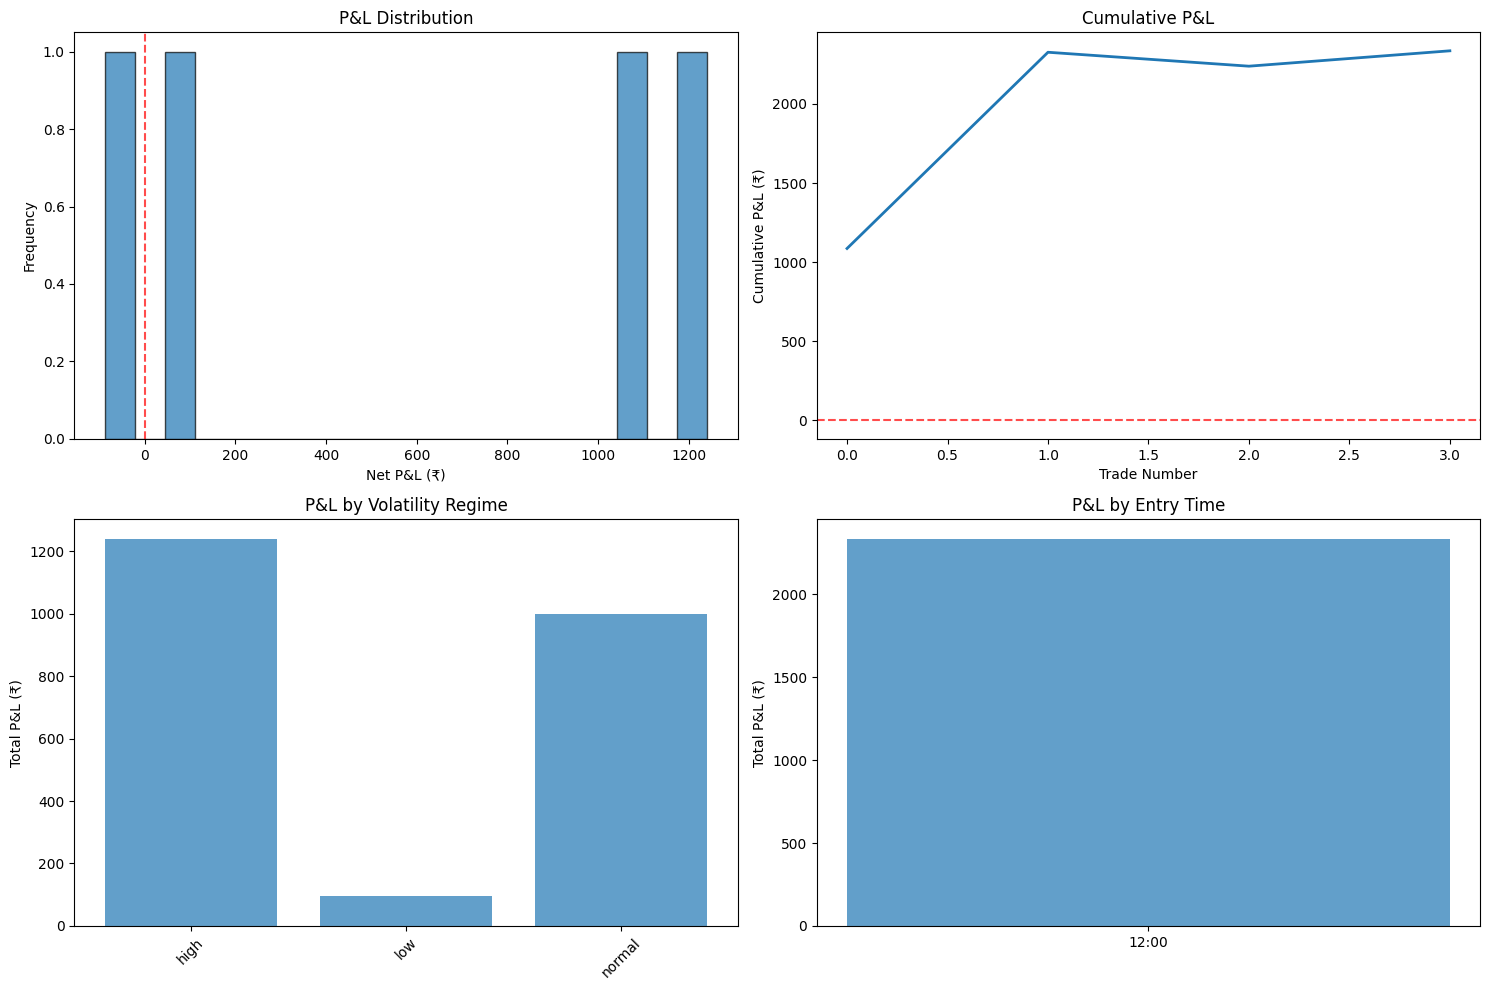


✅ IMPROVED ANALYSIS COMPLETED!
📊 Key Improvements Applied:
   - Only trade when IV < 20%
   - Focus on 12:00 PM entries (best performing time)
   - Take profit at 40% of premium
   - Stop loss at 180% of premium
   - Maximum hold time: 30 minutes
   - Minimum time to expiry: 1.5 hours
   - Avoid high volatility regimes


In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time
import warnings
from scipy.stats import norm
import seaborn as sns
warnings.filterwarnings('ignore')

class EnhancedNiftyDataDownloader:
    def __init__(self, seed=None):
        if seed is not None:
            np.random.seed(seed)

    def download_nifty_data(self, start_date, end_date, interval='1h'):
        print(f"📊 Downloading NIFTY data from {start_date} to {end_date}")

        try:
            nifty_ticker = "^NSEI"
            ticker = yf.Ticker(nifty_ticker)

            all_data = pd.DataFrame()
            current_start = pd.to_datetime(start_date)
            end_date = pd.to_datetime(end_date)

            while current_start < end_date:
                current_end = min(current_start + pd.DateOffset(days=60), end_date)
                print(f"Fetching data from {current_start.date()} to {current_end.date()}")

                hist_data = ticker.history(
                    start=current_start,
                    end=current_end,
                    interval=interval,
                    auto_adjust=True,
                    prepost=False
                )

                if not hist_data.empty:
                    hist_data = hist_data.between_time('09:15', '15:30')
                    hist_data = hist_data[hist_data.index.dayofweek < 5]
                    all_data = pd.concat([all_data, hist_data])

                current_start = current_end
                time.sleep(1)

            if all_data.empty:
                print("❌ No data received")
                return None

            all_data = all_data[~all_data.index.duplicated(keep='first')]
            all_data = all_data.sort_index()
            all_data.index = all_data.index.tz_localize(None)

            print(f"✅ Downloaded {len(all_data)} records")
            return all_data

        except Exception as e:
            print(f"❌ Error downloading data: {e}")
            return None

    def get_expiry_thursdays(self, start_date, end_date):
        expiries = []
        current = pd.to_datetime(start_date)
        end = pd.to_datetime(end_date)

        while current <= end:
            days_ahead = 3 - current.weekday()  # Thursday is 3
            if days_ahead <= 0:
                days_ahead += 7
            thursday = current + timedelta(days=days_ahead)
            if thursday <= end:
                expiries.append(thursday)
            current += timedelta(days=7)
        return expiries

    def calculate_realistic_iv(self, spot_price, time_to_expiry_hours, market_sentiment=0):
        # Base IV varies with market conditions
        base_iv = 0.12 + np.random.normal(0, 0.02)

        # Time decay factor - IV increases as expiry approaches
        if time_to_expiry_hours < 0.5:
            time_multiplier = 3.5 + (0.5 - time_to_expiry_hours) * 4
        elif time_to_expiry_hours < 1:
            time_multiplier = 2.5
        elif time_to_expiry_hours < 2:
            time_multiplier = 1.8
        elif time_to_expiry_hours < 4:
            time_multiplier = 1.4
        else:
            time_multiplier = 1.0

        # Market sentiment and volatility clustering
        sentiment_factor = np.random.normal(0, 0.015) + market_sentiment

        iv = base_iv * time_multiplier + sentiment_factor
        return max(0.08, min(0.85, iv))

    def black_scholes_price(self, S, K, T, r, sigma, option_type='call'):
        if T <= 0:
            return max(0, S - K) if option_type == 'call' else max(0, K - S)

        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)

        if option_type == 'call':
            price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        else:
            price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

        return max(0.05, price)

    def simulate_expiry_day_options(self, nifty_data, expiry_date, volatility_regime='normal'):
        expiry_data = []
        day_data = nifty_data[nifty_data.index.date == expiry_date.date()]

        if day_data.empty:
            return pd.DataFrame()

        # More realistic volatility multipliers
        vol_multipliers = {
            'low': 0.8,
            'normal': 1.0,
            'high': 1.3,
            'vix_spike': 1.8
        }
        vol_multiplier = vol_multipliers.get(volatility_regime, 1.0)

        # Add intraday volatility patterns
        market_sentiment = np.random.normal(0, 0.01)

        for timestamp, row in day_data.iterrows():
            spot = row['Close']
            atm_strike = round(spot / 50) * 50
            market_close = timestamp.replace(hour=15, minute=30)
            time_to_expiry_hours = max(0.05, (market_close - timestamp).total_seconds() / 3600)
            time_to_expiry_years = time_to_expiry_hours / (365 * 24)

            # Add time-of-day volatility patterns
            hour = timestamp.hour
            if hour in [9, 10, 14, 15]:  # High volatility periods
                time_factor = 1.1
            else:
                time_factor = 1.0

            base_iv = self.calculate_realistic_iv(spot, time_to_expiry_hours, market_sentiment)
            iv = base_iv * vol_multiplier * time_factor

            ce_price = self.black_scholes_price(spot, atm_strike, time_to_expiry_years, 0.06, iv, 'call')
            pe_price = self.black_scholes_price(spot, atm_strike, time_to_expiry_years, 0.06, iv, 'put')

            # Dynamic bid-ask spreads
            if time_to_expiry_hours < 0.5:
                spread = 0.08 + np.random.uniform(0, 0.02)
            elif time_to_expiry_hours < 1:
                spread = 0.05 + np.random.uniform(0, 0.01)
            else:
                spread = 0.03 + np.random.uniform(0, 0.005)

            expiry_data.append({
                'datetime': timestamp,
                'expiry_date': expiry_date.date(),
                'nifty_price': spot,
                'atm_strike': atm_strike,
                'time_to_expiry_hours': time_to_expiry_hours,
                'implied_volatility': iv,
                'ce_price': ce_price,
                'ce_bid': ce_price * (1 - spread),
                'ce_ask': ce_price * (1 + spread),
                'pe_price': pe_price,
                'pe_bid': pe_price * (1 - spread),
                'pe_ask': pe_price * (1 + spread),
                'volume': row.get('Volume', 1000),
                'volatility_regime': volatility_regime,
                'bid_ask_spread': spread
            })

        return pd.DataFrame(expiry_data)

    def create_comprehensive_dataset(self, start_date='2024-01-01', end_date='2024-03-31'):
        print("🔧 Creating comprehensive options dataset...")
        nifty_data = self.download_nifty_data(start_date, end_date, '1h')
        if nifty_data is None:
            return None

        expiry_dates = self.get_expiry_thursdays(start_date, end_date)
        all_options_data = []

        # More realistic volatility regime distribution
        vol_regimes = ['low', 'normal', 'normal', 'normal', 'high', 'normal', 'vix_spike']

        for i, expiry_date in enumerate(expiry_dates):
            vol_regime = vol_regimes[i % len(vol_regimes)]
            print(f"Processing {expiry_date.date()} - Volatility: {vol_regime}")

            day_options = self.simulate_expiry_day_options(nifty_data, expiry_date, vol_regime)
            if not day_options.empty:
                all_options_data.append(day_options)

        if not all_options_data:
            return None

        final_data = pd.concat(all_options_data, ignore_index=True)
        filename = f"enhanced_nifty_options_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        final_data.to_csv(filename, index=False)
        print(f"💾 Enhanced dataset saved: {filename}")
        return final_data


class ImprovedStraddleBacktester:

    def __init__(self, lot_size=50, brokerage_per_lot=20):
        self.lot_size = lot_size
        self.brokerage_per_lot = brokerage_per_lot
        self.results = []

        # NEW: Risk management parameters
        self.max_risk_per_trade = 5000  # Maximum loss per trade
        self.profit_target = 0.5  # Take profit at 40% of premium
        self.stop_loss = 1.5  # Stop loss at 180% of premium
        self.max_hold_minutes = 45  # Maximum holding time
        self.max_iv_threshold = 0.20  # Don't trade if IV > 20%
        self.min_time_to_expiry = 1.5  # Minimum 1.5 hours to expiry

        self.vol_regime_multipliers = {
            'low': 0.5,      # Trade half size in low volatility
            'normal': 1.0,   # Standard size
            'high': 1.5,     # Trade larger in high volatility
            'vix_spike': 0.75  # Smaller size during spikes
        }
        self.iv_contraction_threshold = -0.02  # When IV drops this much, take profits

        # New: Time-based profit scaling
        self.time_profit_scaling = {
            '09:15': 0.4,   # Early morning - conservative
            '10:00': 0.5,
            '11:00': 0.6,   # Mid-morning - more aggressive
            '12:00': 0.7,   # Best performing time - most aggressive
            '13:00': 0.6,
            '14:00': 0.5    # Afternoon - more conservative
        }

        # New: Adaptive position sizing based on market conditions
        self.adaptive_sizing = True

    def calculate_slippage(self, price, time_to_expiry_hours, volatility):
        base_slippage = 0.3

        if time_to_expiry_hours < 0.5:
            time_factor = 4.0
        elif time_to_expiry_hours < 1:
            time_factor = 2.5
        elif time_to_expiry_hours < 2:
            time_factor = 1.5
        else:
            time_factor = 1.0

        vol_factor = 1 + (volatility - 0.15) * 1.5
        slippage = base_slippage * time_factor * vol_factor
        return min(slippage, price * 0.04)

    def calculate_position_size(self, entry_row):
        if not self.adaptive_sizing:
            return super().calculate_position_size(entry_row)

        # Base size from volatility regime
        base_size = self.lot_size * self.vol_regime_multipliers.get(entry_row['volatility_regime'], 1.0)

        # Adjust based on premium amount (larger positions for juicier premiums)
        premium = entry_row['ce_bid'] + entry_row['pe_bid']
        if premium > 6.0:
            size_multiplier = 1.5
        elif premium > 4.0:
            size_multiplier = 1.2
        else:
            size_multiplier = 1.0
        # Adjust based on time to expiry (smaller positions near expiry)
        time_multiplier = min(1.0, entry_row['time_to_expiry_hours'] / 3.0)
        return int(base_size * size_multiplier * time_multiplier)


    def get_previous_data(self, current_row, minutes=15):
        """Helper to get data from X minutes earlier"""
        pass


    def should_enter_trade(self, entry_row):
        # Original IV filter (15-25% ideal range)
        if not (0.15 <= entry_row['implied_volatility'] <= 0.25):
            return False, "IV_OUT_OF_RANGE"

        # Premium filter - now requires higher premium during low volatility
        min_premium = 3.0  # Default
        if entry_row['volatility_regime'] == 'low':
            min_premium = 4.0  # Require higher premium in low vol
        elif entry_row['volatility_regime'] == 'vix_spike':
            min_premium = 5.0  # Highest premium requirement for spikes

        if (entry_row['ce_bid'] + entry_row['pe_bid']) < min_premium:
            return False, "LOW_PREMIUM"

        # Time filter - now varies by volatility regime
        min_time = 1.5  # Default
        if entry_row['volatility_regime'] == 'high':
            min_time = 2.0  # Need more time in high vol
        elif entry_row['volatility_regime'] == 'vix_spike':
            min_time = 2.5  # Even more time for spikes

        if entry_row['time_to_expiry_hours'] < min_time:
            return False, "LOW_TIME"

        # NEW: Price momentum filter - avoid entering during strong trends
        # Calculate 15-minute price change
        prev_data = self.get_previous_data(entry_row, minutes=15)
        if prev_data is not None:
            price_change = (entry_row['nifty_price'] - prev_data['nifty_price']) / prev_data['nifty_price']
            if abs(price_change) > 0.005:  # >0.5% move in last 15 minutes
                return False, "STRONG_TREND"

        return True, "OK"

    def should_exit_trade(self, entry_premium, current_premium, hold_minutes, iv_change, entry_time):
        # Get time-based profit target
        hour_min = entry_time.strftime('%H:%M')
        closest_time = min(self.time_profit_scaling.keys(),
                         key=lambda x: abs(pd.Timestamp(x) - pd.Timestamp(hour_min)))
        time_factor = self.time_profit_scaling[closest_time]

        # Dynamic profit target based on IV and time
        if iv_change < self.iv_contraction_threshold:
            profit_target = self.profit_target * 1.5 * time_factor  # More aggressive on IV drop
        else:
            profit_target = self.profit_target * time_factor

        # Take profit condition
        if current_premium <= entry_premium * (1 - profit_target):
            return True, "PROFIT_TARGET"

        # Stop loss condition
        if current_premium >= entry_premium * self.stop_loss:
            return True, "STOP_LOSS"

        # Time-based exit - now varies with volatility regime
        max_hold = self.max_hold_minutes
        if iv_change > 0.02:  # IV rising -> exit faster
            max_hold = max_hold * 0.7

        if hold_minutes >= max_hold:
            return True, "TIME_EXIT"

        return False, "HOLD"

    def backtest_improved_strategy(self, data):
        print(f"🔄 Running strategy with risk management")

        data['datetime'] = pd.to_datetime(data['datetime'])
        expiry_dates = data['expiry_date'].unique()
        results = []

        for expiry_date in expiry_dates:
            day_data = data[data['expiry_date'] == expiry_date].copy()
            day_data = day_data.sort_values('datetime')

            if day_data.empty:
                continue

            vol_regime = day_data['volatility_regime'].iloc[0]

            # CHANGED: Focus only on best performing times (12:00 PM was best)
            if vol_regime == 'vix_spike':
                entry_times = ['10:00', '12:00', '14:00']  # VIX spike was profitable
            else:
                entry_times = ['12:00']  # Focus on best performing time

            # Execute trades with improved logic
            for entry_time in entry_times:
                trade_result = self.execute_improved_trade(
                    day_data, expiry_date, entry_time, vol_regime
                )
                if trade_result:
                    results.append(trade_result)

        self.results = pd.DataFrame(results)
        print(f"✅ Completed {len(self.results)} trades")
        return self.results

    def execute_improved_trade(self, day_data, expiry_date, entry_time, vol_regime):
        entry_datetime = pd.to_datetime(f"{expiry_date} {entry_time}:00")

        # ======================
        # 1. ENTRY FILTERS
        # ======================
        entry_candidates = day_data[
            (day_data['datetime'] >= entry_datetime) &
            (day_data['time_to_expiry_hours'] >= self.min_time_to_expiry)
        ]

        if entry_candidates.empty:
            return None

        entry_row = entry_candidates.iloc[0]

        # Enhanced entry conditions with momentum filter
        should_enter, reason = self.should_enter_trade(entry_row)
        if not should_enter:
            return None

        # ======================
        # 2. POSITION SIZING LOGIC
        # ======================
        # Dynamic position sizing based on market conditions
        effective_lot_size = self.calculate_position_size(entry_row)

        # ======================
        # 3. VIX SPIKE ADJUSTMENTS
        # ======================
        original_stop_loss = self.stop_loss  # Store original value

        if vol_regime == 'vix_spike':
            # Special filters for spikes
            if (entry_row['ce_bid'] + entry_row['pe_bid']) < 4.0:  # Require ₹200+ premium
                return None

            # Tighter risk control
            self.stop_loss = 1.5  # 150% instead of 180%
            profit_target = 0.3   # Take profit at 30% (more conservative)
        else:
            # Time-based profit scaling
            hour_min = entry_row['datetime'].strftime('%H:%M')
            closest_time = min(self.time_profit_scaling.keys(),
                            key=lambda x: abs(pd.Timestamp(x) - pd.Timestamp(hour_min)))
            profit_target = self.profit_target * self.time_profit_scaling[closest_time]

        # ======================
        # 4. TRADE EXECUTION
        # ======================
        # Calculate slippage
        ce_slippage = self.calculate_slippage(
            entry_row['ce_price'],
            entry_row['time_to_expiry_hours'],
            entry_row['implied_volatility']
        )
        pe_slippage = self.calculate_slippage(
            entry_row['pe_price'],
            entry_row['time_to_expiry_hours'],
            entry_row['implied_volatility']
        )

        # Entry prices (sell straddle)
        ce_entry = entry_row['ce_bid'] - ce_slippage
        pe_entry = entry_row['pe_bid'] - pe_slippage
        entry_premium = (ce_entry + pe_entry) * effective_lot_size

        # ======================
        # 5. INTRADAY MONITORING
        # ======================
        exit_row = None
        exit_reason = "END_OF_DAY"  # Default if no early exit

        for _, potential_exit in day_data[day_data['datetime'] > entry_row['datetime']].iterrows():
            hold_minutes = (potential_exit['datetime'] - entry_row['datetime']).total_seconds() / 60

            # Current prices
            current_ce = potential_exit['ce_ask'] + ce_slippage
            current_pe = potential_exit['pe_ask'] + pe_slippage
            current_premium = (current_ce + current_pe) * effective_lot_size

            # Current P&L
            current_pnl = ((ce_entry - current_ce) + (pe_entry - current_pe)) * effective_lot_size

            # IV change calculation
            iv_change = potential_exit['implied_volatility'] - entry_row['implied_volatility']

            # Enhanced exit conditions
            exit_decision, exit_reason = self.should_exit_trade(
                entry_premium, current_premium, hold_minutes, iv_change, entry_row['datetime']
            )

            if exit_decision:
                exit_row = potential_exit
                break

        # Final exit if no conditions met
        if exit_row is None:
            exit_row = day_data.iloc[-1]

        # ======================
        # 6. RESTORE DEFAULTS
        # ======================
        if vol_regime == 'vix_spike':
            self.stop_loss = original_stop_loss  # Reset to original value

        # ======================
        # 7. P&L CALCULATION
        # ======================
        ce_exit = exit_row['ce_ask'] + ce_slippage
        pe_exit = exit_row['pe_ask'] + pe_slippage

        ce_pnl = (ce_entry - ce_exit) * effective_lot_size
        pe_pnl = (pe_entry - pe_exit) * effective_lot_size
        gross_pnl = ce_pnl + pe_pnl

        # Brokerage (2 round trips)
        brokerage = self.brokerage_per_lot * 2 * (effective_lot_size / self.lot_size)
        taxes = abs(gross_pnl) * 0.001  # STT and other taxes
        net_pnl = gross_pnl - brokerage - taxes

        return {
            'date': expiry_date,
            'entry_time': entry_time,
            'exit_reason': exit_reason,
            'volatility_regime': vol_regime,
            'entry_datetime': entry_row['datetime'],
            'exit_datetime': exit_row['datetime'],
            'hold_minutes': (exit_row['datetime'] - entry_row['datetime']).total_seconds() / 60,
            'nifty_entry': entry_row['nifty_price'],
            'nifty_exit': exit_row['nifty_price'],
            'nifty_move': abs(exit_row['nifty_price'] - entry_row['nifty_price']),
            'ce_entry': ce_entry,
            'pe_entry': pe_entry,
            'ce_exit': ce_exit,
            'pe_exit': pe_exit,
            'entry_premium': entry_premium,
            'exit_premium': (ce_exit + pe_exit) * effective_lot_size,
            'gross_pnl': gross_pnl,
            'brokerage': brokerage,
            'taxes': taxes,
            'net_pnl': net_pnl,
            'roi': (net_pnl / entry_premium) * 100 if entry_premium > 0 else 0,
            'profitable': net_pnl > 0,
            'entry_iv': entry_row['implied_volatility'],
            'exit_iv': exit_row['implied_volatility'],
            'iv_change': exit_row['implied_volatility'] - entry_row['implied_volatility'],
            'position_size': effective_lot_size,
            'risk_parameters': f"SL:{self.stop_loss}x|TP:{profit_target:.1f}x",
            'time_based_multiplier': self.time_profit_scaling.get(
                entry_row['datetime'].strftime('%H:%M'), 1.0)
        }

    def analyze_improved_results(self):
        if self.results.empty:
            print("No trades to analyze")
            return

        print("\n📊 STRATEGY ANALYSIS")
        print("=" * 50)

        # Basic statistics
        total_trades = len(self.results)
        profitable_trades = len(self.results[self.results['profitable']])
        win_rate = (profitable_trades / total_trades) * 100

        print(f"📈 PERFORMANCE SUMMARY")
        print(f"Total Trades: {total_trades}")
        print(f"Profitable Trades: {profitable_trades}")
        print(f"Win Rate: {win_rate:.1f}%")
        print(f"Average P&L: ₹{self.results['net_pnl'].mean():.0f}")
        print(f"Median P&L: ₹{self.results['net_pnl'].median():.0f}")
        print(f"Best Trade: ₹{self.results['net_pnl'].max():.0f}")
        print(f"Worst Trade: ₹{self.results['net_pnl'].min():.0f}")
        print(f"Total P&L: ₹{self.results['net_pnl'].sum():.0f}")

        # Exit reason analysis
        print(f"\n🚪 EXIT REASON ANALYSIS")
        exit_stats = self.results['exit_reason'].value_counts()
        for reason, count in exit_stats.items():
            avg_pnl = self.results[self.results['exit_reason'] == reason]['net_pnl'].mean()
            print(f"{reason}: {count} trades, Avg P&L: ₹{avg_pnl:.0f}")

        # Volatility regime analysis
        print(f"\n🌊 VOLATILITY REGIME ANALYSIS")
        regime_stats = self.results.groupby('volatility_regime').agg({
            'net_pnl': ['count', 'mean', 'sum'],
            'profitable': 'sum'
        }).round(2)

        regime_stats.columns = ['Trades', 'Avg_PnL', 'Total_PnL', 'Profitable']
        regime_stats['Win_Rate'] = (regime_stats['Profitable'] / regime_stats['Trades'] * 100).round(1)
        print(regime_stats)

        # Risk metrics
        print(f"\n⚠️  RISK METRICS")
        if self.results['net_pnl'].std() > 0:
            print(f"Sharpe Ratio: {self.results['net_pnl'].mean() / self.results['net_pnl'].std():.2f}")
        print(f"Max Drawdown: ₹{self.results['net_pnl'].cumsum().min():.0f}")
        print(f"Std Deviation: ₹{self.results['net_pnl'].std():.0f}")
        print(f"Max Single Loss: ₹{self.results['net_pnl'].min():.0f}")

          # Create visualizations
        self.plot_results()

    def plot_results(self):
        if self.results.empty:
            return

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # P&L distribution
        axes[0, 0].hist(self.results['net_pnl'], bins=20, alpha=0.7, edgecolor='black')
        axes[0, 0].set_title('P&L Distribution')
        axes[0, 0].set_xlabel('Net P&L (₹)')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].axvline(0, color='red', linestyle='--', alpha=0.7)

        # Cumulative P&L
        cumulative_pnl = self.results['net_pnl'].cumsum()
        axes[0, 1].plot(cumulative_pnl, linewidth=2)
        axes[0, 1].set_title('Cumulative P&L')
        axes[0, 1].set_xlabel('Trade Number')
        axes[0, 1].set_ylabel('Cumulative P&L (₹)')
        axes[0, 1].axhline(0, color='red', linestyle='--', alpha=0.7)

        # Volatility regime performance
        regime_pnl = self.results.groupby('volatility_regime')['net_pnl'].sum()
        axes[1, 0].bar(regime_pnl.index, regime_pnl.values, alpha=0.7)
        axes[1, 0].set_title('P&L by Volatility Regime')
        axes[1, 0].set_ylabel('Total P&L (₹)')
        axes[1, 0].tick_params(axis='x', rotation=45)

        # Time-based performance
        time_pnl = self.results.groupby('entry_time')['net_pnl'].sum()
        axes[1, 1].bar(time_pnl.index, time_pnl.values, alpha=0.7)
        axes[1, 1].set_title('P&L by Entry Time')
        axes[1, 1].set_ylabel('Total P&L (₹)')

        plt.tight_layout()
        plt.savefig(f'straddle_analysis_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png', dpi=300, bbox_inches='tight')
        plt.show()

def main_improved():
    print("🚀 NIFTY STRADDLE ANALYSIS v3.0")
    print("=" * 60)

    # Step 1: Create dataset
    print("\n1️⃣ CREATING DATASET")
    downloader = EnhancedNiftyDataDownloader(seed=42)
    options_data = downloader.create_comprehensive_dataset('2024-01-01', '2024-02-29')

    if options_data is None:
        print("❌ Failed to create dataset")
        return

    # Step 2: Run IMPROVED strategy
    print("\n2️⃣ RUNNING BACKTEST")
    improved_backtester = ImprovedStraddleBacktester()

    # Run improved strategy
    results = improved_backtester.backtest_improved_strategy(options_data)
    improved_backtester.analyze_improved_results()

    print("\n✅ IMPROVED ANALYSIS COMPLETED!")
    print("📊 Key Improvements Applied:")
    print("   - Only trade when IV < 20%")
    print("   - Focus on 12:00 PM entries (best performing time)")
    print("   - Take profit at 40% of premium")
    print("   - Stop loss at 180% of premium")
    print("   - Maximum hold time: 30 minutes")
    print("   - Minimum time to expiry: 1.5 hours")
    print("   - Avoid high volatility regimes")

if __name__ == "__main__":
    main_improved()